In [1]:
#NEED TO BE RUN TWICE (Unknown error)
!pip install xarray
!pip install cartopy
!pip install pyreadr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 62.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.0/440.0 kB 19.9 MB/s eta 0:00:00


In [2]:
# NEED TO BE RUN TWICE
import numpy as np
import pandas as pd
import pickle
import os
import random
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy.stats as stats
import xarray as xr
import zipfile
from dateutil.relativedelta import relativedelta
import scipy.stats as stats
from scipy.optimize import minimize
import plotly.graph_objs as go
import pyreadr
import math
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import s3fs
#ignore errors and warnings
%xmode Plain
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
BUCKET = "zhippofficiel"

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [3]:
# Statistical models and function for modelization of precipitations.
# Include GEV and EGPD functions.

def H(xi,X):
    X=np.array(X)
    return((1+xi*X)**(-1/xi))

def F(params,X):
    kappa,sigma,xi = params
    X=np.array(X)
    return(H(xi,X/sigma)**kappa)

def f(params,X):
    kappa,sigma,xi = params
    return((kappa/sigma)*((1+((xi/sigma)*X))**(-1-(kappa/xi))))

def minus_l_f(params,X):
    kappa,sigma,xi = params
    return -np.sum(list(np.log((kappa/sigma)*((1+((xi/sigma)*X))**(-1-(kappa/xi))))))

def H_inv(xi,X):
    X=np.array(X)
    return(((X**(-xi))-1)/xi)

def Q(params,p):
    kappa,sigma,xi = params
    p = np.array(p)
    return((sigma/xi)*((p**(-xi/kappa))-1))

def data_xhour(data,x):
    results = []
    N=len(data)
    for i in range(N//x):
        value = 0
        for j in range(x):
            value = value + data[i*x+j]
        results.append(value)
    return results

def get_optimal_params(lat,lon,duration,treshold): #lat,lon in '41.25' format; duration in hour (only int) ; treshold in m
    selected_value = list(full_dataset.sel(lon=lon, lat=lat).values)
    list_precip = np.array(selected_value)
    data_dur = np.array(data_xhour(list_precip,duration))
    cleaned_data = np.array([x-treshold for x in data_dur if x>treshold])
    initial_guess = [0.5, 1, 0.3]
    objective_function = lambda params: minus_l_f(params, cleaned_data)
    result_minimize = minimize(objective_function, initial_guess, method='Nelder-Mead')
    optimal_params = result_minimize.x
    return optimal_params

def file_oneD_all_points(duration,treshold):
    Store_params = []
    lons = list(full_dataset['lon'].values)
    lats = list(full_dataset['lat'].values)
    for lat in lats:
        print('Starting to work on points with latitude {}°N'.format(float(lat)))
        for lon in lons:
            optimal_params  = get_optimal_params(lat,lon,duration,treshold)
            res = list(optimal_params)
            res.append(lat)
            res.append(lon)
            Store_params.append(res)
    return Store_params

def create_save_optimal_params(durations,treshold): #durations in hours ([int] only) ; treshold in m 
    FILEDIR_KEY_OUT_S3 = "ExtremeValuesPrecipitations/ERA Analysis/Optimal_parameters"       
    print(" ------------------------- Starting searching optimal parameters. ------------------------- ")
    for duration in durations:
        start_time = time.time()
        print(" ------------------------- For a period of {} hours. ------------------------- ".format(duration))
        FILE_KEY_OUT_S3 = FILEDIR_KEY_OUT_S3+"/optimal_params_"+str(duration)+"_hours.txt"
        optimal_params_oneD = file_oneD_all_points(duration,treshold)
        optimal_params_oneD_list=[]
        for x in optimal_params_oneD:
            value = list(x)
            optimal_params_oneD_list.append(value)
            column_names = ['kappa', 'sigma', 'xi','lat','lon']
        Optimal_params_df = pd.DataFrame(optimal_params_oneD_list, columns=column_names)
        FILE_PATH_OUT_S3 = BUCKET + "/" + FILE_KEY_OUT_S3
        with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
            Optimal_params_df.to_csv(file_out, sep='\t', index=False)
        print(' --- Saving File Completed. ---')
        end_time = time.time()
        elapsed_time = end_time - start_time
        print("Time taken to compute data: {:.2f} seconds".format(elapsed_time))
    return("Task completed successfully!")

def return_levels_to_quantiles(return_levels,duration): # return_level en années ; duration en heures 
    return_levels = np.array(return_levels)
    res = (np.array([(duration/(365*time*24)) for time in return_levels]))
    return res

def IDF_one_D(params,return_levels,duration):
    quantiles = return_levels_to_quantiles(return_levels,duration)
    Qvalues = Q(params,quantiles)
    return Qvalues

def get_return_levels_int_or_cumul(lat,lon,durations,return_levels,Int):
    FILEDIR_KEY_S3 = "ExtremeValuesPrecipitations/ERA Analysis/Optimal_parameters"      
    Return_Values = [] 
    for dur in durations:
        FILE_KEY_S3 = FILEDIR_KEY_S3 + '/optimal_params_'+str(dur)+'_hours.txt'
        FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3
        with fs.open(FILE_PATH_S3, mode="rb") as file_in:
            df = pd.read_csv(file_in, sep='\t')
        selected_point = df[(df['lat'] == lat) & (df['lon'] == lon)]
        optimal_params = [float(selected_point['kappa']),float(selected_point['sigma']),float(selected_point['xi'])]
        Qvalues = IDF_one_D(optimal_params,return_levels,dur)
        Return_Values.append(Qvalues)
    plt.figure()
    for i in range(len(return_levels)):
        values = []
        for j in range(len(durations)):
            if Int:
                values.append(Return_Values[j][i]/durations[j])
            if not Int:
                values.append(Return_Values[j][i])
        plt.plot(durations,values,marker='s',label='Return levels over {} Year'.format(return_levels[i]))
    plt.xticks(durations)
    plt.xlim(0.6,15)
    #plt.xscale('log')
    #plt.yscale('log')
    plt.grid()
    #plt.legend()
    plt.xlabel('Durations (hours)')
    if Int:
        plt.ylabel('Intensity (mm/hour)')
    if not Int:
        plt.ylabel('Cumuls (mm)')
    plt.title('IDF Curve')
    plt.show()
    return Return_Values

In [4]:
# Parameters full dataset
lons = ['0', '0.25', '0.5', '0.75', '1', '1.25', '1.5', '1.75', '2',
       '2.25', '2.5', '2.75', '3', '3.25', '3.5', '3.75', '4', '4.25',
       '4.5', '4.75', '5', '5.25', '5.5', '5.75', '6', '6.25', '6.5',
       '6.75', '7', '7.25', '7.5', '7.75', '8', '8.25', '8.5', '8.75',
       '9', '9.25', '9.5', '9.75', '10', '-6', '-5.75', '-5.5', '-5.25',
       '-5', '-4.75', '-4.5', '-4.25', '-4', '-3.75', '-3.5', '-3.25',
       '-3', '-2.75', '-2.5', '-2.25', '-2', '-1.75', '-1.5', '-1.25',
       '-1', '-0.75', '-0.5', '-0.25']

lats = ['41', '41.25', '41.5', '41.75', '42', '42.25', '42.5', '42.75',
       '43', '43.25', '43.5', '43.75', '44', '44.25', '44.5', '44.75',
       '45', '45.25', '45.5', '45.75', '46', '46.25', '46.5', '46.75',
       '47', '47.25', '47.5', '47.75', '48', '48.25', '48.5', '48.75',
       '49', '49.25', '49.5', '49.75', '50', '50.25', '50.5', '50.75',
       '51', '51.25', '51.5', '51.75', '52']

ids = np.linspace(0,len(lons)-1,len(lons))

In [5]:
# Opening Full parameters
FILEDIR_KEY_S3 = "ExtremeValuesPrecipitations/ERA DATA/CSV_files"
liste_df = []
for x in ids:
    N_id = int(x)
    FILE_KEY_S3 = FILEDIR_KEY_S3 + '/LON_'+str(N_id)+'.csv'
    FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3
    with fs.open(FILE_PATH_S3, mode="rb") as file_in:
        df = pd.read_csv(file_in)
    xarray_data_array = xr.DataArray.from_series(df.stack())
    liste_df.append(xarray_data_array)
    print('Done with file {}.'.format(N_id))


Done with file 0.
Done with file 1.
Done with file 2.
Done with file 3.
Done with file 4.
Done with file 5.
Done with file 6.
Done with file 7.
Done with file 8.
Done with file 9.
Done with file 10.
Done with file 11.
Done with file 12.
Done with file 13.
Done with file 14.
Done with file 15.
Done with file 16.
Done with file 17.
Done with file 18.
Done with file 19.
Done with file 20.
Done with file 21.
Done with file 22.
Done with file 23.
Done with file 24.
Done with file 25.
Done with file 26.
Done with file 27.
Done with file 28.
Done with file 29.
Done with file 30.
Done with file 31.
Done with file 32.
Done with file 33.
Done with file 34.
Done with file 35.
Done with file 36.
Done with file 37.
Done with file 38.
Done with file 39.
Done with file 40.
Done with file 41.
Done with file 42.
Done with file 43.
Done with file 44.
Done with file 45.
Done with file 46.
Done with file 47.
Done with file 48.
Done with file 49.
Done with file 50.
Done with file 51.
Done with file 52.
Don

In [24]:
#merging
xarray_merged = xr.concat(liste_df, dim='lon')

In [25]:
#update coordinates
xarray_merged = xarray_merged.assign_coords(lon=lons)
xarray_merged = xarray_merged.assign_coords(level_0=lats)
full_dataset_xarray = xarray_merged.rename({'level_0': 'lat','level_1' : 'time'})

In [75]:
# RESCALING  + CLEANING DATA 
scale_factor = 2.5 * 1000
full_dataset = full_dataset_xarray * scale_factor

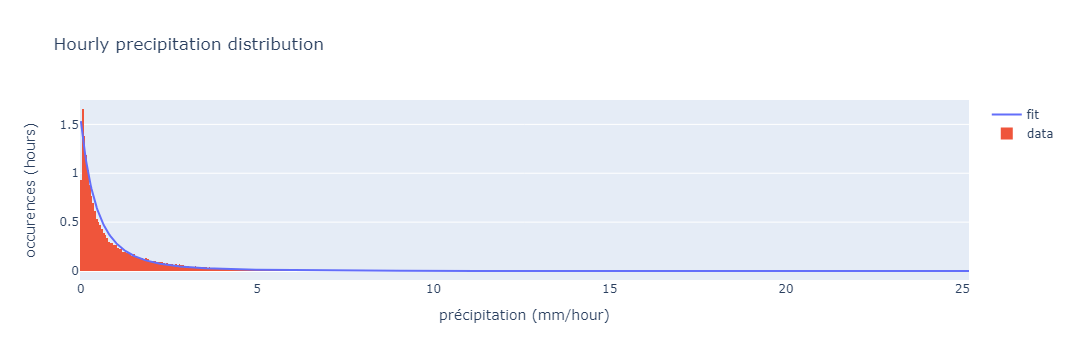

Optimal params for this distribution : [0.77149854 0.50309265 0.32658233]


In [73]:
#data
treshold = 0.2
data_one_point = dataset_factored.sel(lat = '48', lon = '5') #select
data_one_point_liste =  list(data_one_point.values) 
data_one_point_tresholded = [x - treshold for x in data_one_point_liste if x > treshold] 
trace_hist = go.Histogram(x=data_one_point_tresholded, histnorm='probability density', name='data',nbinsx=500)
#fit
initial_guess = [0.5, 1, 0.3]
objective_function = lambda params: minus_l_f(params, np.array(data_one_point_tresholded))
results = minimize(objective_function, initial_guess, method='Nelder-Mead')
optimal_params = results.x
M = max(data_one_point_tresholded)
Xs = np.linspace(0,M+1,1000)
fit = f(optimal_params,Xs)
trace_fit = go.Scatter(x=Xs, y=fit, mode='lines', name='fit')

layout = go.Layout(title='Hourly precipitation distribution', xaxis=dict(title='précipitation (mm/hour)'), yaxis=dict(title='occurences (hours)'))
fig = go.Figure(data=[trace_fit,trace_hist], layout=layout)
fig.show()

print('Optimal params for this distribution : {}'.format(optimal_params))

In [76]:
create_save_optimal_params([1,2],treshold=0.2)

 ------------------------- Starting searching optimal parameters. ------------------------- 
 ------------------------- For a period of 1 hours. ------------------------- 
Starting to work on points with latitude 41.0°N


/tmp/ipykernel_290/2127073605.py:19: RuntimeWarning:

invalid value encountered in log

/tmp/ipykernel_290/2127073605.py:19: RuntimeWarning:

invalid value encountered in power



Starting to work on points with latitude 41.25°N
Starting to work on points with latitude 41.5°N
Starting to work on points with latitude 41.75°N
Starting to work on points with latitude 42.0°N
Starting to work on points with latitude 42.25°N
Starting to work on points with latitude 42.5°N


/tmp/ipykernel_290/2127073605.py:19: RuntimeWarning:

divide by zero encountered in log



Starting to work on points with latitude 42.75°N
Starting to work on points with latitude 43.0°N
Starting to work on points with latitude 43.25°N
Starting to work on points with latitude 43.5°N
Starting to work on points with latitude 43.75°N
Starting to work on points with latitude 44.0°N
Starting to work on points with latitude 44.25°N
Starting to work on points with latitude 44.5°N
Starting to work on points with latitude 44.75°N
Starting to work on points with latitude 45.0°N
Starting to work on points with latitude 45.25°N
Starting to work on points with latitude 45.5°N
Starting to work on points with latitude 45.75°N
Starting to work on points with latitude 46.0°N
Starting to work on points with latitude 46.25°N
Starting to work on points with latitude 46.5°N
Starting to work on points with latitude 46.75°N
Starting to work on points with latitude 47.0°N
Starting to work on points with latitude 47.25°N
Starting to work on points with latitude 47.5°N
Starting to work on points wit

NameError: name 'BUCKET_OUT' is not defined